In [1]:
import h5py

with h5py.File('data.h5', 'r') as hf:
    input_data = hf['input_data'][:]  # type: ignore[index]
    output_data = hf['output_data'][:]  # type: ignore[index]


/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
import torch
from torch.utils.data import random_split, TensorDataset
import numpy as np

# Assuming input_data and output_data are numpy arrays
# Convert numpy arrays to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
output_tensor = torch.tensor(output_data, dtype=torch.float32)

# Create a combined dataset
dataset = TensorDataset(input_tensor, output_tensor/np.mean(output_data[:,2]))

# Define the sizes for training and testing datasets
train_size = int(0.01 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and testing datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Get the X and y for training and testing
X_train = train_dataset[:][0]
y_train = train_dataset[:][1]
X_test = test_dataset[:][0]
y_test = test_dataset[:][1]

print(f"Size of training dataset: {len(train_dataset)}")
print(f"Size of testing dataset: {len(test_dataset)}")


Size of training dataset: 1512
Size of testing dataset: 149719


In [27]:
import sched
import torch
import torch.nn as nn
import torch.optim as optim

# Check if CUDA is available and set the device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define the autoencoder model


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder: Linear layers with ReLU activation
        self.encoder = nn.Sequential(
            nn.Linear(26, 50),
            nn.Tanh(),
            nn.Linear(50, 4),
            nn.Sigmoid()
        )

        # Decoder: Linear layers with ReLU activation
        self.decoder = nn.Sequential(
            nn.Linear(4, 50),
            nn.Tanh(),
            nn.Linear(50, 26)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Assume data_array is your numpy array of shape (n, 26)
data_array = y_train  # replace with your data
tensor_data = torch.tensor(data_array, dtype=torch.float32).to(device)

# Initialize the autoencoder, optimizer, and loss function
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=200, verbose=True, factor=0.5)

# Training the autoencoder
epochs = 200000
for epoch in range(epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(tensor_data)

    # Compute loss
    loss = criterion(outputs, tensor_data)
    scheduler.step(loss)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss every 100 epochs
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.6f}, learning rate: {optimizer.param_groups[0]["lr"]:.7f}')

# Using the encoder and decoder separately
# Encoding
with torch.no_grad():
    encoded_data = model.encoder(tensor_data)
    print('Encoded Data: ', encoded_data.cpu())  # move tensor to CPU for printing

# Decoding
with torch.no_grad():
    decoded_data = model.decoder(encoded_data)
    print('Decoded Data: ', decoded_data.cpu())  # move tensor to CPU for printing

cuda
Epoch [0/200000], Loss: 9.663515, learning rate: 0.0001000


/tmp/ipykernel_742681/3183145234.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_data = torch.tensor(data_array, dtype=torch.float32).to(device)


Epoch [1000/200000], Loss: 1.172758, learning rate: 0.0001000
Epoch [2000/200000], Loss: 0.312776, learning rate: 0.0001000
Epoch [3000/200000], Loss: 0.207114, learning rate: 0.0001000
Epoch [4000/200000], Loss: 0.132291, learning rate: 0.0001000
Epoch [5000/200000], Loss: 0.080941, learning rate: 0.0001000
Epoch [6000/200000], Loss: 0.054665, learning rate: 0.0001000
Epoch [7000/200000], Loss: 0.039987, learning rate: 0.0001000
Epoch [8000/200000], Loss: 0.020312, learning rate: 0.0001000
Epoch [9000/200000], Loss: 0.006357, learning rate: 0.0001000
Epoch [10000/200000], Loss: 0.003263, learning rate: 0.0001000
Epoch [11000/200000], Loss: 0.002274, learning rate: 0.0001000
Epoch [12000/200000], Loss: 0.001864, learning rate: 0.0001000
Epoch [13000/200000], Loss: 0.001627, learning rate: 0.0001000
Epoch [14000/200000], Loss: 0.001466, learning rate: 0.0001000
Epoch [15000/200000], Loss: 0.001284, learning rate: 0.0001000
Epoch [16000/200000], Loss: 0.001013, learning rate: 0.0001000
E

In [9]:
# Using the encoder and decoder separately
# Encoding
with torch.no_grad():
    encoded_data = model.encoder(tensor_data)
    print('Encoded Data: ', encoded_data.cpu())  # move tensor to CPU for printing

# Decoding
with torch.no_grad():
    decoded_data = model.decoder(encoded_data)
    print('Decoded Data: ', decoded_data.cpu())  # move tensor to CPU for printing

Encoded Data:  tensor([[0.3507, 0.4754, 0.5852, 0.6533],
        [0.6171, 0.4842, 0.5966, 0.5721],
        [0.5257, 0.5709, 0.5727, 0.6054],
        ...,
        [0.5376, 0.5506, 0.6641, 0.5662],
        [0.5400, 0.5329, 0.6546, 0.5565],
        [0.4322, 0.5141, 0.5965, 0.6405]])
Decoded Data:  tensor([[8.9920, 4.5980, 1.5441,  ..., 2.4919, 2.4722, 2.4674],
        [8.9912, 4.3160, 1.0431,  ..., 3.3166, 3.3133, 3.3125],
        [8.9897, 4.0916, 0.6699,  ..., 2.8940, 2.8784, 2.8746],
        ...,
        [8.9864, 4.3167, 1.0421,  ..., 2.9141, 2.8898, 2.8839],
        [8.9890, 4.3606, 1.1121,  ..., 2.9678, 2.9508, 2.9466],
        [8.9905, 4.4141, 1.2162,  ..., 2.6717, 2.6483, 2.6424]])


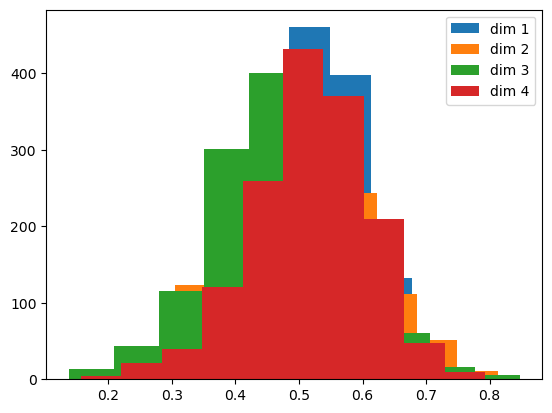

In [28]:
import matplotlib.pyplot as plt
for i in range(4):
    plt.hist(encoded_data.cpu().numpy()[:, i], bins=10)

plt.legend(['dim 1', 'dim 2', 'dim 3', 'dim 4', 'dim 5'])

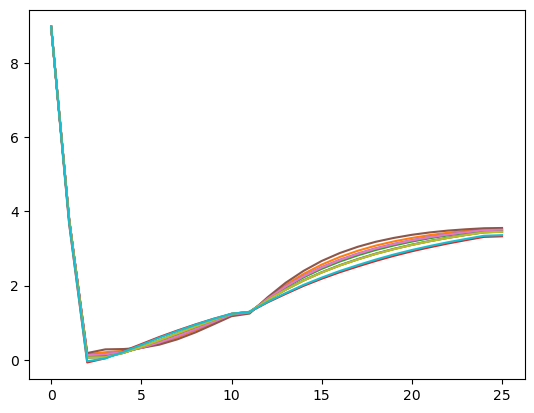

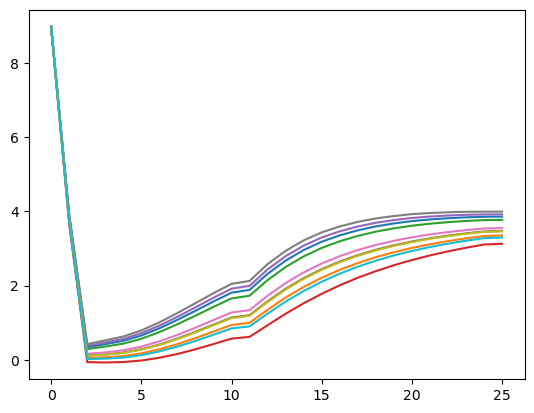

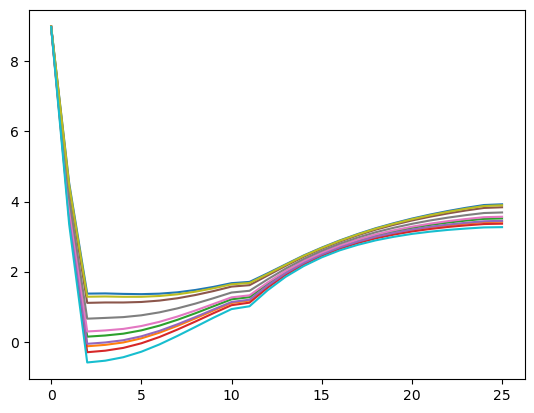

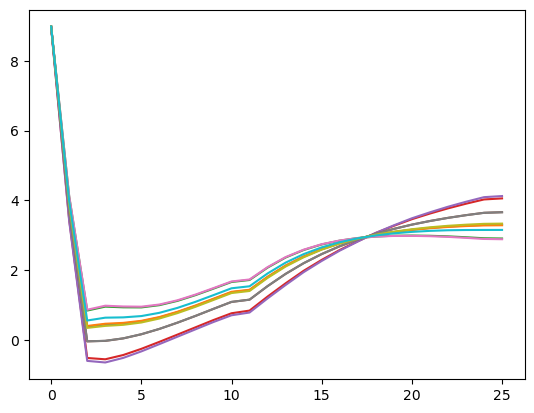

In [80]:
tmp = torch.tensor(np.random.rand(1, 4), dtype=torch.float32).to(device)

for i in range(10):
    tmp3 = (np.random.rand(1, 4) - 0.5) / 2
    tmp3[0,0] = 0
    tmp3[0,1] = 0
    tmp3[0,2] = 0
    # tmp3[0,3] = 0
    tmp2 = model.decoder(tmp+torch.tensor(tmp3, dtype=torch.float32).to(device))
    plt.plot(tmp2.to('cpu').detach().numpy().ravel())
plt.show()
for i in range(10):
    tmp3 = (np.random.rand(1, 4) - 0.5) / 2
    tmp3[0, 0] = 0
    tmp3[0, 1] = 0
    # tmp3[0, 2] = 0
    tmp3[0,3] = 0
    tmp2 = model.decoder(tmp + torch.tensor(tmp3, dtype=torch.float32).to(device))
    plt.plot(tmp2.to('cpu').detach().numpy().ravel())
plt.show()
for i in range(10):
    tmp3 = (np.random.rand(1, 4) - 0.5) / 2
    tmp3[0, 0] = 0
    # tmp3[0, 1] = 0
    tmp3[0, 2] = 0
    tmp3[0,3] = 0
    tmp2 = model.decoder(tmp + torch.tensor(tmp3, dtype=torch.float32).to(device))
    plt.plot(tmp2.to('cpu').detach().numpy().ravel())
plt.show()
for i in range(10):
    tmp3 = (np.random.rand(1, 4) - 0.5) / 2
    # tmp3[0, 0] = 0
    tmp3[0, 1] = 0
    tmp3[0, 2] = 0
    tmp3[0,3] = 0
    tmp2 = model.decoder(tmp + torch.tensor(tmp3, dtype=torch.float32).to(device))
    plt.plot(tmp2.to('cpu').detach().numpy().ravel())
plt.show()

In [82]:
outputs = model(y_test.to(device))
loss = criterion(outputs, y_test.to(device))
print(loss)

tensor(1.8805e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


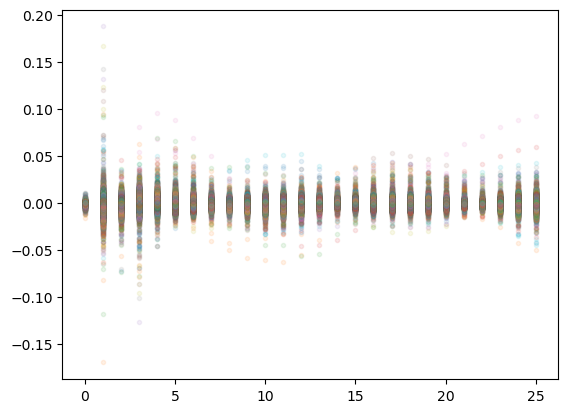

In [98]:

for i in range(10000):
    plt.plot(outputs[i, :].cpu().detach().numpy() - y_test[i, :].cpu().detach().numpy(), ".",alpha=0.1)    
plt.show()

In [103]:
y_train2 = model.encoder(y_train.to(device))
y_test2 = model.encoder(y_test.to(device))

In [102]:
y_train2.shape

torch.Size([1512, 4])

In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

n_lyer = 100
# Step 1: Define the Neural Network Architecture


class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, y_train2.shape[1])
        )

    def forward(self, x):
        return self.layers(x)


# Step 2: Move the Model to GPU if Available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = MLPRegressor().to(device)

# Step 3: Define a Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.5)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = X_train.clone().detach().to(device).float()
X_test_tensor = X_test.clone().detach().to(device).float()
y_train_tensor = y_train2.clone().detach().to(device).float()
y_test_tensor = y_test2.clone().detach().to(device).float()

loss_train = []
loss_test = []
# Step 5: Train the Model
max_iter = 200000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    if iteration % 100 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, Learning rate: {optimizer.param_groups[0]["lr"]}.')
        loss_train.append(loss.item())
        loss_test.append(criterion(model(X_test_tensor), y_test_tensor).item())

Using cuda device
Iteration 0, Loss: 0.29907602071762085, Learning rate: 0.001.
Iteration 100, Loss: 0.006616980768740177, Learning rate: 0.001.
Iteration 200, Loss: 0.006093957461416721, Learning rate: 0.001.
Iteration 300, Loss: 0.005659607704728842, Learning rate: 0.001.
Iteration 400, Loss: 0.004933646880090237, Learning rate: 0.001.
Iteration 500, Loss: 0.0037910405080765486, Learning rate: 0.001.
Iteration 600, Loss: 0.0029927892610430717, Learning rate: 0.001.
Iteration 700, Loss: 0.0024617917370051146, Learning rate: 0.001.
Iteration 800, Loss: 0.0020999261178076267, Learning rate: 0.001.
Iteration 900, Loss: 0.001843114965595305, Learning rate: 0.001.
Iteration 1000, Loss: 0.0016412122640758753, Learning rate: 0.001.
Iteration 1100, Loss: 0.0014615205582231283, Learning rate: 0.001.
Iteration 1200, Loss: 0.0012878425186499953, Learning rate: 0.001.
Iteration 1300, Loss: 0.0011241151951253414, Learning rate: 0.001.
Iteration 1400, Loss: 0.0009877285920083523, Learning rate: 0.0

KeyboardInterrupt: 

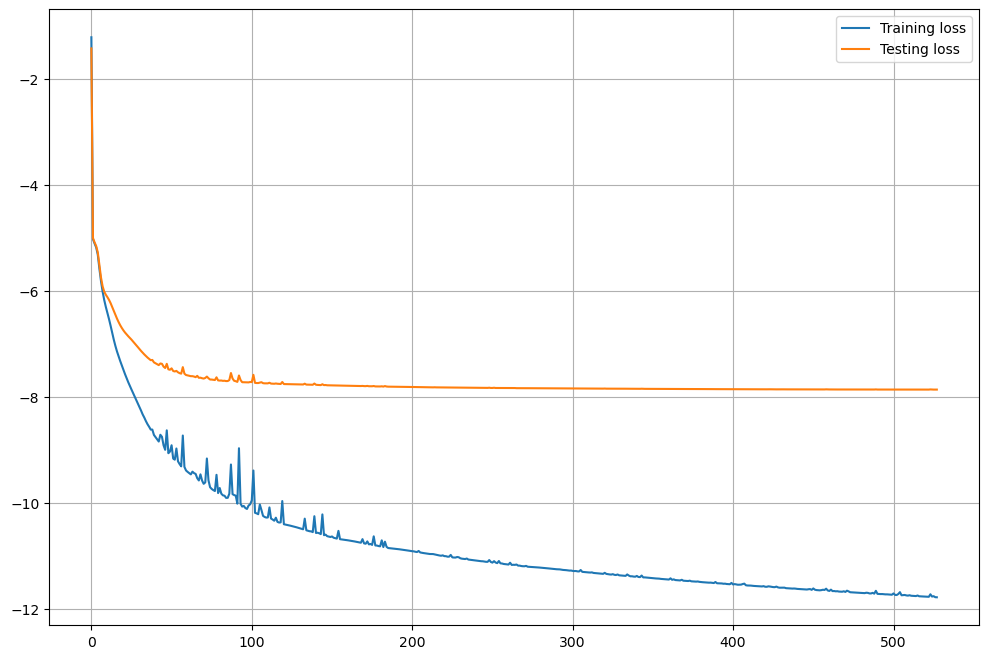

In [106]:
# plot loss_train and loss_test in log scale
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(np.log(loss_train), label='Training loss')
plt.plot(np.log(loss_test), label='Testing loss')
# add grid
plt.grid()
plt.legend()

In [92]:
import torch
from torch.utils.data import random_split, TensorDataset

# Assuming input_data and output_data are numpy arrays
# Convert numpy arrays to PyTorch tensors
input_tensor = torch.tensor(input_data, dtype=torch.float32)
output_tensor = torch.tensor(output_data, dtype=torch.float32)

# Create a combined dataset
dataset = TensorDataset(input_tensor, output_tensor)

# Define the sizes for training and testing datasets
train_size = int(0.01 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into training and testing datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Get the X and y for training and testing
X_train = train_dataset[:][0]
y_train = train_dataset[:][1]
X_test = test_dataset[:][0]
y_test = test_dataset[:][1]

print(f"Size of training dataset: {len(train_dataset)}")
print(f"Size of testing dataset: {len(test_dataset)}")


Size of training dataset: 1512
Size of testing dataset: 149719


In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

n_lyer = 10
# Step 1: Define the Neural Network Architecture


class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, y_train.shape[1])
        )

    def forward(self, x):
        return self.layers(x)


# Step 2: Move the Model to GPU if Available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = MLPRegressor().to(device)

# Step 3: Define a Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.5)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = X_train.clone().detach().to(device).float()
X_test_tensor = X_test.clone().detach().to(device).float()
y_train_tensor = y_train.clone().detach().to(device).float()
y_test_tensor = y_test.clone().detach().to(device).float()

loss_train = []
loss_test = []
# Step 5: Train the Model
max_iter = 200000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)


    if iteration % 100 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, Learning rate: {optimizer.param_groups[0]["lr"]}.')
        loss_train.append(loss.item())
        loss_test.append(criterion(model(X_test_tensor), y_test_tensor).item())



Using cuda device
Iteration 0, Loss: 8964.591796875, Learning rate: 0.001.
Iteration 100, Loss: 8766.875, Learning rate: 0.001.
Iteration 200, Loss: 8501.9833984375, Learning rate: 0.001.
Iteration 300, Loss: 8294.9384765625, Learning rate: 0.001.
Iteration 400, Loss: 8106.15673828125, Learning rate: 0.001.
Iteration 500, Loss: 7927.35498046875, Learning rate: 0.001.
Iteration 600, Loss: 7755.59814453125, Learning rate: 0.001.
Iteration 700, Loss: 7589.46142578125, Learning rate: 0.001.
Iteration 800, Loss: 7428.125, Learning rate: 0.001.
Iteration 900, Loss: 7271.0625, Learning rate: 0.001.
Iteration 1000, Loss: 7117.90673828125, Learning rate: 0.001.
Iteration 1100, Loss: 6968.38623046875, Learning rate: 0.001.
Iteration 1200, Loss: 6822.2919921875, Learning rate: 0.001.
Iteration 1300, Loss: 6679.45166015625, Learning rate: 0.001.
Iteration 1400, Loss: 6539.72607421875, Learning rate: 0.001.
Iteration 1500, Loss: 6402.99462890625, Learning rate: 0.001.
Iteration 1600, Loss: 6269.153

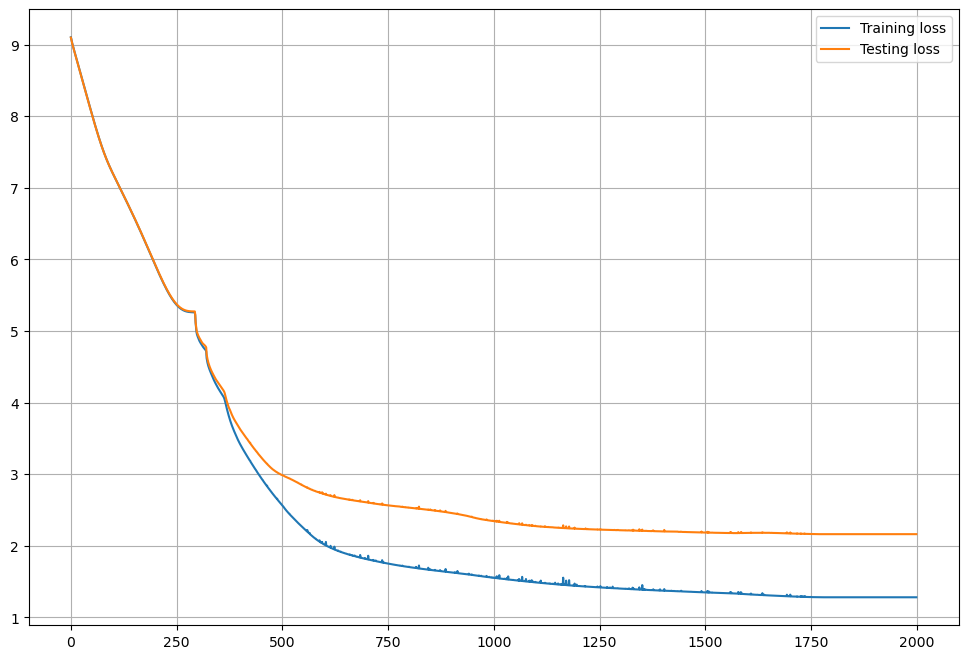

In [109]:
# plot loss_train and loss_test in log scale
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(np.log(loss_train), label='Training loss')
plt.plot(np.log(loss_test), label='Testing loss')
# add grid
plt.grid()
plt.legend()

In [111]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

n_lyer = 100
# Step 1: Define the Neural Network Architecture


class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, n_lyer),
            nn.Tanh(),
            nn.Linear(n_lyer, y_train.shape[1])
        )

    def forward(self, x):
        return self.layers(x)


# Step 2: Move the Model to GPU if Available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')
model = MLPRegressor().to(device)

# Step 3: Define a Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Add a learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.5)

# Step 4: Convert Numpy Data to PyTorch Tensors and Move to Device
X_train_tensor = X_train.clone().detach().to(device).float()
X_test_tensor = X_test.clone().detach().to(device).float()
y_train_tensor = y_train.clone().detach().to(device).float()
y_test_tensor = y_test.clone().detach().to(device).float()

loss_train = []
loss_test = []
# Step 5: Train the Model
max_iter = 200000
for iteration in range(max_iter):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)


    if iteration % 100 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, Learning rate: {optimizer.param_groups[0]["lr"]}.')
        loss_train.append(loss.item())
        loss_test.append(criterion(model(X_test_tensor), y_test_tensor).item())



Using cuda device
Iteration 0, Loss: 8966.685546875, Learning rate: 0.0001.
Iteration 100, Loss: 8888.43359375, Learning rate: 0.0001.
Iteration 200, Loss: 8690.6435546875, Learning rate: 0.0001.
Iteration 300, Loss: 8393.8125, Learning rate: 0.0001.
Iteration 400, Loss: 8094.0029296875, Learning rate: 0.0001.
Iteration 500, Loss: 7831.8017578125, Learning rate: 0.0001.
Iteration 600, Loss: 7605.36962890625, Learning rate: 0.0001.
Iteration 700, Loss: 7404.0693359375, Learning rate: 0.0001.
Iteration 800, Loss: 7220.279296875, Learning rate: 0.0001.
Iteration 900, Loss: 7049.2490234375, Learning rate: 0.0001.
Iteration 1000, Loss: 6887.9814453125, Learning rate: 0.0001.
Iteration 1100, Loss: 6734.5185546875, Learning rate: 0.0001.
Iteration 1200, Loss: 6587.52392578125, Learning rate: 0.0001.
Iteration 1300, Loss: 6446.04833984375, Learning rate: 0.0001.
Iteration 1400, Loss: 6309.39501953125, Learning rate: 0.0001.
Iteration 1500, Loss: 6177.037109375, Learning rate: 0.0001.
Iteration

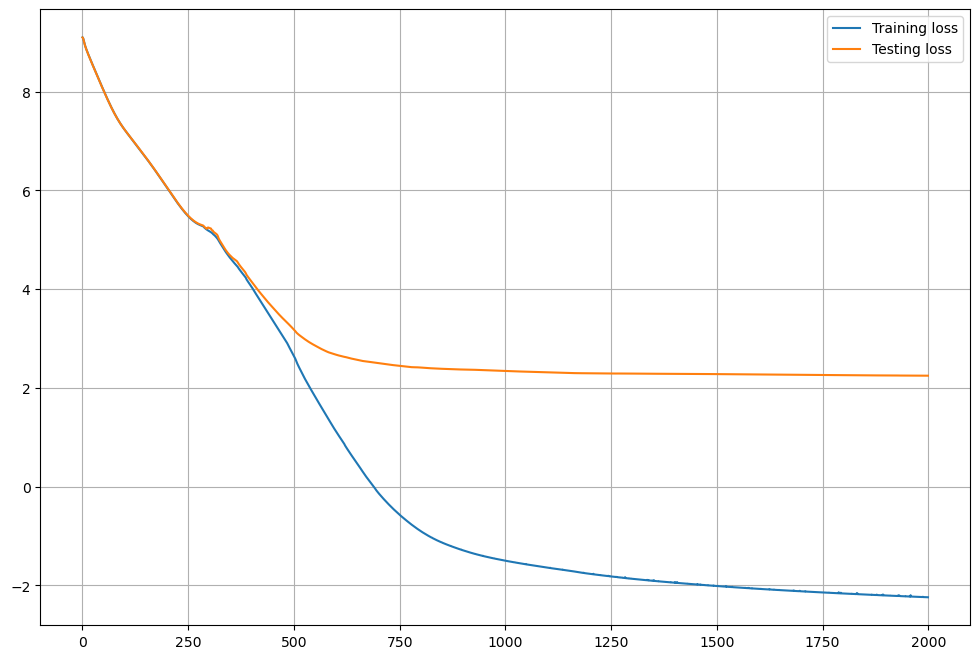

In [112]:
# plot loss_train and loss_test in log scale
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(np.log(loss_train), label='Training loss')
plt.plot(np.log(loss_test), label='Testing loss')
# add grid
plt.grid()
plt.legend()

In [90]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Create dataset and dataloader
batch_size = 64
dataset = CustomDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Step 3: Define a Loss Function and Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2 * len(dataloader), factor=0.85)
# Train the model with mini-batch training
max_epochs = 2000

loss_train_fine = []
loss_test_fine = []

for epoch in range(max_epochs):
    loss_max = 0
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        loss_max = max(loss_max, loss.item())

    loss_train_fine.append(criterion(model(X_train_tensor), y_train_tensor).item())
    loss_test_fine.append(criterion(model(X_test_tensor), y_test_tensor).item())
    print(f'Epoch {epoch}, Loss: {loss_max},  Learning rate: {optimizer.param_groups[0]["lr"]}')

Epoch 0, Loss: 0.02030201442539692,  Learning rate: 1e-05
Epoch 1, Loss: 0.01797362044453621,  Learning rate: 1e-05
Epoch 2, Loss: 0.016204314306378365,  Learning rate: 8.5e-06
Epoch 3, Loss: 0.01924838125705719,  Learning rate: 8.5e-06
Epoch 4, Loss: 0.02072378806769848,  Learning rate: 7.2249999999999994e-06
Epoch 5, Loss: 0.017878595739603043,  Learning rate: 7.2249999999999994e-06
Epoch 6, Loss: 0.01982666552066803,  Learning rate: 7.2249999999999994e-06
Epoch 7, Loss: 0.01923871971666813,  Learning rate: 7.2249999999999994e-06
Epoch 8, Loss: 0.015699252486228943,  Learning rate: 6.141249999999999e-06
Epoch 9, Loss: 0.018366334959864616,  Learning rate: 6.141249999999999e-06
Epoch 10, Loss: 0.01944868080317974,  Learning rate: 5.220062499999999e-06
Epoch 11, Loss: 0.018881358206272125,  Learning rate: 5.220062499999999e-06
Epoch 12, Loss: 0.016363898292183876,  Learning rate: 5.220062499999999e-06
Epoch 13, Loss: 0.016370590776205063,  Learning rate: 4.4370531249999995e-06
Epoch 14

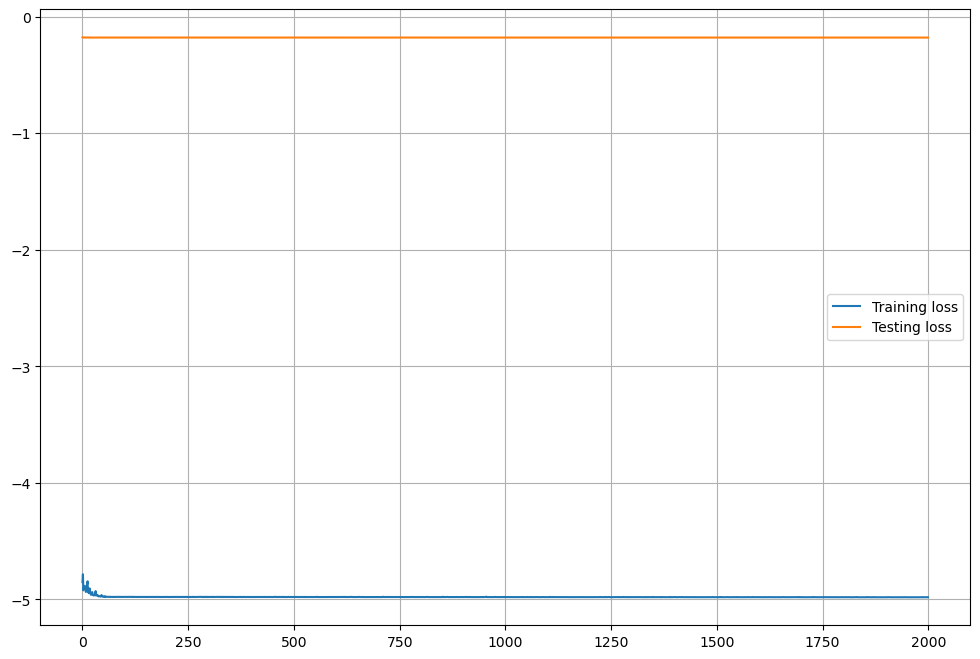

In [91]:
# plot loss_train and loss_test in log scale
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.plot(np.log(loss_train_fine), label='Training loss')
plt.plot(np.log(loss_test_fine), label='Testing loss')
# add grid
plt.grid()
plt.legend()

/tmp/ipykernel_55273/2095710087.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)


0.15901982290011915


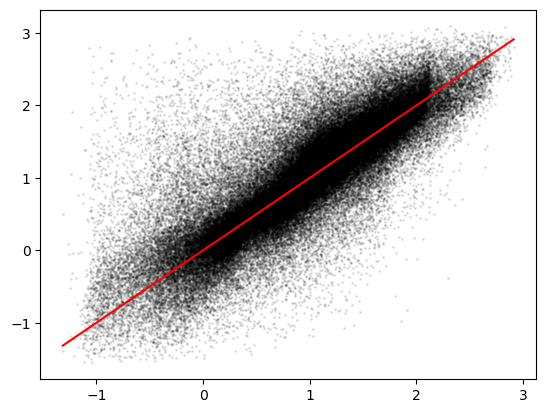

In [53]:
# Step 6: Test the Model
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
res_surr = model(X_test_tensor).detach().cpu().numpy()
from matplotlib import pyplot as plt
# plot line x=y from -40 to 100

for i in range(1):
    plt.plot([np.min(res_surr[:,i]), np.max(res_surr[:,i])], [np.min(res_surr[:,i]), np.max(res_surr[:,i])], 'r')
    plt.scatter(res_surr[:,i], y_test[:,i], alpha=0.1, s=1,c='k')
    print(np.sum((res_surr[:,i] - y_test[:,i].detach().cpu().numpy()) ** 2 ) / len(y_test[:,0]))
    plt.show()

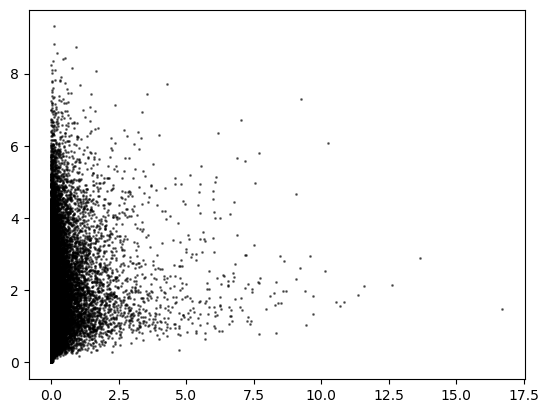

In [44]:
plt.scatter((res_surr[:,0] - y_test[:,0].detach().cpu().numpy())**2,np.sum(X_test_tensor.detach().cpu().numpy()**2,axis=1), alpha=0.5, s=1,c='k')

9.99544266093251e-07


/tmp/ipykernel_55273/4046298074.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)


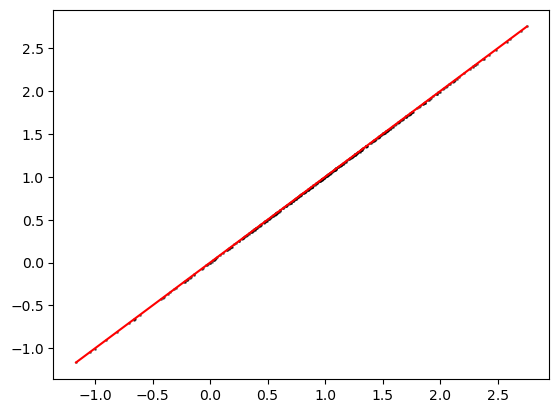

In [45]:
# Step 6: Test the Model
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
res_surr = model(X_train_tensor).detach().cpu().numpy()
for i in range(1):
    plt.plot([np.min(res_surr[:,i]), np.max(res_surr[:,i])], [np.min(res_surr[:,i]), np.max(res_surr[:,i])], 'r')
    plt.scatter(res_surr[:,i], y_train[:,i], alpha=0.5, s=1,c='k')
    print(np.sum((res_surr[:,i] - y_train[:,i].detach().cpu().numpy()) ** 2 ) / len(y_train[:,0]))
    plt.show()